In [ ]:
# Transfer Learning (Food vision mini)
# using full data set 
# 101 classes of food
# Goal is to beat the og food 101 paper by using 10 percent of training 
# data, using feature extraction and fine tuning.


In [ ]:
!nvidia-smi

Sat Jan  7 05:42:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Creating helper functions.
!wget https://raw.githubusercontent.com/nish16111/DeepLearning_TensorFlow/main/reused_functions.py


--2023-01-07 05:42:36--  https://raw.githubusercontent.com/nish16111/DeepLearning_TensorFlow/main/reused_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8655 (8.5K) [text/plain]
Saving to: ‘reused_functions.py’

reused_functions.py 100%[===================>]   8.45K  --.-KB/s    in 0s      

2023-01-07 05:42:37 (92.9 MB/s) - ‘reused_functions.py’ saved [8655/8655]



In [ ]:
# Import series of reused_functions for our project.
from reused_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-01-07 05:42:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   167MB/s    in 8.2s    

2023-01-07 05:42:48 (188 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in 

In [ ]:
import tensorflow as tf

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = "categorical",
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size = IMAGE_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE,
                                                                image_size = IMAGE_SIZE,
                                                                shuffle = False) # do not shuffle test_data for prediction analysis.
                                                                

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training a big dog model w tranfer learning on 10% of food 101 classes.

Steps:
* Create a model_checkpoint_callback
* Create a data aug layer to build data aug right into the model 
* Build a headless (no top layers) Functional EfficentNeB0 backBoned-model(will create our own output layer)
* Compile
* Feature Extract for 5 epochs on train data set, validate for 15% test data

In [ ]:
# Create a model_checpoint_callback. (saves model patterns)
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = "val_accuracy",
                                                      save_weights_only = True)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2)
    # preprocessing.Rescaling(1/255.) rescale images for models like resnet
], name = "data_augmentation")

In [ ]:
# Setup base model with frozen layers.
# Lil Tidbits: (if models are there, inputs could be passed inisde the braces ),
# and if layers are present the inputs are needed to be passed outside the braces of the layers.

base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

input_layer = tf.keras.Input(shape = (224, 224, 3),
                             name = "input_layer")

x = data_augmentation(input_layer) #augment imgs (only happens during training)

x = base_model(x, training = False) #Put the base model in inference mode so the wights which need too stay, frozen stay frozen.

x = tf.keras.layers.GlobalAveragePooling2D(name = "Pooling_layer")(x)

output_layer = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax",
                                     name = "output_layer")(x)

model_0 = tf.keras.Model(input_layer, output_layer)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
history_all_classes_10_percent = model_0.fit(train_data_all_10_percent,
                                            epochs = 5,
                                            steps_per_epoch = len(train_data_all_10_percent),
                                            validation_data = test_data,
                                            validation_steps = int(0.15 * len(test_data)),
                                            callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 101s 368ms/step - loss: 3.3641 - accuracy: 0.2734 - val_loss: 2.4270 - val_accuracy: 0.4714
Epoch 2/5
237/237 [==============================] - 69s 288ms/step - loss: 2.1913 - accuracy: 0.5035 - val_loss: 1.9956 - val_accuracy: 0.5196
Epoch 3/5
237/237 [==============================] - 64s 268ms/step - loss: 1.8130 - accuracy: 0.5727 - val_loss: 1.8355 - val_accuracy: 0.5355
Epoch 4/5
237/237 [==============================] - 59s 248ms/step - loss: 1.5929 - accuracy: 0.6062 - val_loss: 1.7770 - val_accuracy: 0.5379
Epoch 5/5
237/237 [==============================] - 54s 228ms/step - loss: 1.4474 - accuracy: 0.6418 - val_loss: 1.7526 - val_accuracy: 0.5432


In [ ]:
fine_tuning_results = model_0.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 59s 75ms/step - loss: 1.5713 - accuracy: 0.5884


[1.5712660551071167, 0.5883564352989197]

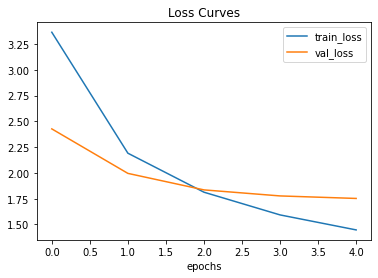

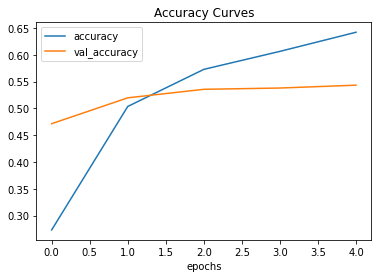

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [ ]:
for layer_number, layer in enumerate(model_0.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Unfreeze all the layers

layer.trainable = True

# Refreeze every layer except last 5.
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(model_0.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

**Note**
Layers closest to the input layers learn the larger features,
such as roundness, edges of pizza etc, however layers closer,
to the o/p layer usually learn the finer grained features, hence
Unfreezing the layers closer to the o/p layers is more beneficial,
and efficient.

In [ ]:
# Recpmpile with lower Learning rate (typically best practice to recompile with lower lr when fine-tuning).

model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(0.0001),
                metrics = ["accuracy"])

In [ ]:
# What layers in the model_0 are trainable
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
Pooling_layer True
output_layer True


In [ ]:
# Fit the model_0 using fine_tuning.

fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model_0.fit(train_data_all_10_percent,
                                                       epochs = fine_tune_epochs,
                                                       steps_per_epoch = len(train_data_all_10_percent),
                                                       initial_epoch = history_all_classes_10_percent.epoch[-1],
                                                       validation_data = test_data,
                                                       validation_steps = int(0.15 * len(test_data)))


Epoch 5/10
237/237 [==============================] - 62s 237ms/step - loss: 1.2788 - accuracy: 0.6920 - val_loss: 1.7257 - val_accuracy: 0.5482
Epoch 6/10
237/237 [==============================] - 51s 215ms/step - loss: 1.2582 - accuracy: 0.7010 - val_loss: 1.7197 - val_accuracy: 0.5501
Epoch 7/10
237/237 [==============================] - 54s 228ms/step - loss: 1.2600 - accuracy: 0.6987 - val_loss: 1.7154 - val_accuracy: 0.5501
Epoch 8/10
237/237 [==============================] - 50s 211ms/step - loss: 1.2363 - accuracy: 0.7068 - val_loss: 1.7070 - val_accuracy: 0.5530
Epoch 9/10
237/237 [==============================] - 51s 213ms/step - loss: 1.2265 - accuracy: 0.7138 - val_loss: 1.7059 - val_accuracy: 0.5522
Epoch 10/10
237/237 [==============================] - 47s 195ms/step - loss: 1.2064 - accuracy: 0.7172 - val_loss: 1.7074 - val_accuracy: 0.5519


In [ ]:
all_classes_10_percent_fine_tune_results = model_0.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 57s 72ms/step - loss: 1.5314 - accuracy: 0.5956


[1.5313538312911987, 0.5956435799598694]

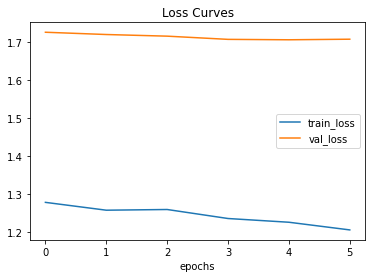

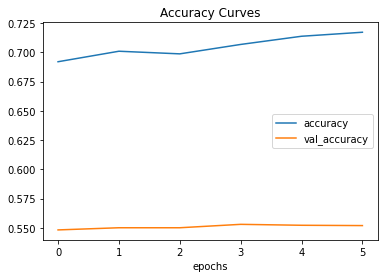

In [ ]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

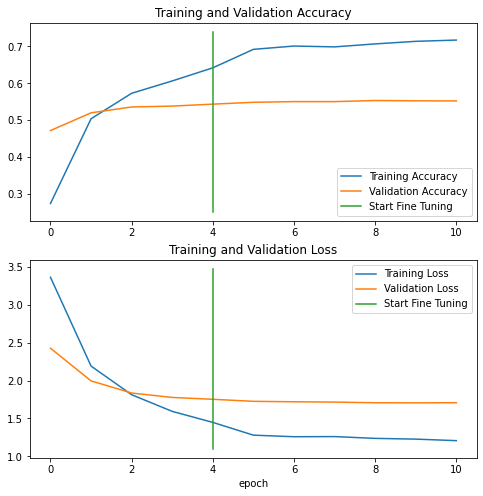

In [ ]:
compare_historys(history_all_classes_10_percent,
                 history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading our model.
To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# save the fine_tune_model
model_0.save("drive/MyDrive/Colab Notebooks/101_food_classes_saved__big_dog_model")

In [ ]:
# Load and evaluate the saved moodel.
loaded_model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/101_food_classes_saved__big_dog_model")

In [ ]:
# Evaluate the model.
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results, all_classes_10_percent_fine_tune_results

790/790 [==============================] - 60s 74ms/step - loss: 1.5314 - accuracy: 0.5956


([1.5313538312911987, 0.5956435799598694],
 [1.5313538312911987, 0.5956435799598694])

## Evaluating performances of the big dog model across all different classes.
Make some predictions, visualize them and, then later find out which predictions are most wrong.

In [ ]:
import tensorflow as tf
# Download the pre trained model one that was trained earlier, so all predictions are similar.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-01-07 05:59:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 74.125.70.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   142MB/s    in 0.3s    

2023-01-07 05:59:19 (142 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
loaded_model_results = model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 61s 75ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with trained model

In [ ]:
pred_probs = model.predict(test_data, verbose = 1) #set verbosity to see how long is left


790/790 [==============================] - 64s 80ms/step


In [ ]:
pred_probs

array([[5.9542041e-02, 3.5742053e-06, 4.1376803e-02, ..., 1.4138708e-09,
        8.3530598e-05, 3.0897530e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286946e-05,
        7.8361918e-12, 9.8465647e-10],
       [9.5925879e-01, 3.2533717e-05, 1.4866921e-03, ..., 7.1891350e-07,
        5.4397532e-07, 4.0276082e-05],
       ...,
       [1.5138779e-05, 4.0973077e-04, 8.0250906e-10, ..., 2.1742910e-05,
        1.0797232e-05, 5.3789955e-01],
       [5.9318207e-03, 4.9236543e-03, 9.9823344e-03, ..., 1.1989499e-04,
        1.6890328e-05, 4.5218006e-02],
       [3.1363461e-02, 7.5052152e-03, 4.2975016e-04, ..., 5.0346350e-04,
        5.2055889e-06, 6.9062936e-01]], dtype=float32)

In [ ]:
# Number of predictions.
len(pred_probs)

25250

In [ ]:
pred_probs[25249]

array([3.13634612e-02, 7.50521524e-03, 4.29750158e-04, 1.36518770e-08,
       1.03165175e-05, 3.05590442e-09, 4.69293664e-05, 1.56150752e-11,
       5.42647322e-04, 5.42008706e-07, 4.86274657e-04, 1.45595846e-09,
       2.68920157e-05, 2.13489585e-07, 1.13508497e-04, 1.78642452e-07,
       1.55008317e-03, 2.27503871e-04, 6.32390402e-06, 2.24107189e-05,
       1.35688414e-03, 4.93967927e-05, 1.92305641e-04, 1.07843301e-03,
       3.84835439e-05, 8.10896890e-05, 1.25129213e-06, 1.24079989e-07,
       1.10774581e-05, 5.56722810e-08, 8.75781936e-08, 6.47299876e-03,
       5.75316960e-07, 3.80868840e-07, 3.10621950e-09, 6.16698969e-07,
       2.93410358e-06, 4.13331036e-05, 1.80268216e-06, 7.99167261e-04,
       5.96723380e-03, 3.53330984e-06, 3.56714893e-03, 6.15307840e-07,
       8.42997783e-10, 3.28935101e-08, 1.73284250e-04, 1.46827733e-04,
       3.53589276e-11, 3.11934184e-02, 5.42358088e-04, 2.47666435e-07,
       3.95901725e-02, 1.37291063e-04, 3.13539381e-08, 6.13470729e-06,
      

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
# First ten preds
pred_probs[:10]

array([[5.9542041e-02, 3.5742053e-06, 4.1376803e-02, ..., 1.4138708e-09,
        8.3530598e-05, 3.0897530e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286946e-05,
        7.8361918e-12, 9.8465647e-10],
       [9.5925879e-01, 3.2533717e-05, 1.4866921e-03, ..., 7.1891350e-07,
        5.4397532e-07, 4.0276082e-05],
       ...,
       [4.7313261e-01, 1.2931234e-07, 1.4805571e-03, ..., 5.9750129e-04,
        6.6969093e-05, 2.3469318e-05],
       [4.4571854e-02, 4.7265522e-07, 1.2258522e-01, ..., 6.3498674e-06,
        7.5318649e-06, 3.6778811e-03],
       [7.2438961e-01, 1.9249846e-09, 5.2310996e-05, ..., 1.2291390e-03,
        1.5792685e-09, 9.6395743e-05]], dtype=float32)

In [ ]:
pred_probs[0]
# This displayed here is a prediction probability array.

array([5.9542041e-02, 3.5742053e-06, 4.1376803e-02, 1.0660536e-09,
       8.1613978e-09, 8.6639664e-09, 8.0927055e-07, 8.5652584e-07,
       1.9859037e-05, 8.0977844e-07, 3.1727685e-09, 9.8673934e-07,
       2.8532150e-04, 7.8048906e-10, 7.4230199e-04, 3.8916383e-05,
       6.4740493e-06, 2.4977257e-06, 3.7891168e-05, 2.0678289e-07,
       1.5538468e-05, 8.1507341e-07, 2.6230621e-06, 2.0010727e-07,
       8.3827535e-07, 5.4215934e-06, 3.7391037e-06, 1.3150533e-08,
       2.7761499e-03, 2.8051867e-05, 6.8562162e-10, 2.5574906e-05,
       1.6688929e-04, 7.6407003e-10, 4.0452901e-04, 1.3150634e-08,
       1.7957395e-06, 1.4448203e-06, 2.3062935e-02, 8.2466863e-07,
       8.5365861e-07, 1.7138630e-06, 7.0525307e-06, 1.8402273e-08,
       2.8553430e-07, 7.9483771e-06, 2.0681496e-06, 1.8525223e-07,
       3.3619774e-08, 3.1522568e-04, 1.0410943e-05, 8.5448448e-07,
       8.4741873e-01, 1.0555466e-05, 4.4094878e-07, 3.7404185e-05,
       3.5306264e-05, 3.2489010e-05, 6.7314875e-05, 1.2852592e

In [ ]:
tf.argmax(pred_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=52>

In [ ]:
train_data_all_10_percent.class_names[52]

'gyoza'

In [ ]:
sum(pred_probs[0])

1.0000000363815253

The model outpts a prediction probability array(with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [ ]:
max(pred_probs[0])

0.8474187

In [ ]:
print(f"Number of prediction probabilities for sample 0 : {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n{pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {tf.argmax(pred_probs[0])}")
print(f"The name of the class with highest predicted probability is: {test_data.class_names[52]}")


Number of prediction probabilities for sample 0 : 101
What prediction probability sample 0 looks like:
[5.9542041e-02 3.5742053e-06 4.1376803e-02 1.0660536e-09 8.1613978e-09
 8.6639664e-09 8.0927055e-07 8.5652584e-07 1.9859037e-05 8.0977844e-07
 3.1727685e-09 9.8673934e-07 2.8532150e-04 7.8048906e-10 7.4230199e-04
 3.8916383e-05 6.4740493e-06 2.4977257e-06 3.7891168e-05 2.0678289e-07
 1.5538468e-05 8.1507341e-07 2.6230621e-06 2.0010727e-07 8.3827535e-07
 5.4215934e-06 3.7391037e-06 1.3150533e-08 2.7761499e-03 2.8051867e-05
 6.8562162e-10 2.5574906e-05 1.6688929e-04 7.6407003e-10 4.0452901e-04
 1.3150634e-08 1.7957395e-06 1.4448203e-06 2.3062935e-02 8.2466863e-07
 8.5365861e-07 1.7138630e-06 7.0525307e-06 1.8402273e-08 2.8553430e-07
 7.9483771e-06 2.0681496e-06 1.8525223e-07 3.3619774e-08 3.1522568e-04
 1.0410943e-05 8.5448448e-07 8.4741873e-01 1.0555466e-05 4.4094878e-07
 3.7404185e-05 3.5306264e-05 3.2489010e-05 6.7314875e-05 1.2852592e-08
 2.6219760e-10 1.0318110e-05 8.5744046e-05 1.

In [ ]:
# Get the pred classes for each label.
pred_classes = pred_probs.argmax(axis = 1)

# How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [ ]:
len(pred_classes)

25250

Now we have got predictions array of all of our model's predictions, to evaluate them, we need to compare them to the orignal dataset labels.

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# To get our test_labels we need to unravel the test_data BAtch dataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) 

y_labels[:10] # look at first ten

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

25250

## Evaluating our model's predictions
One way to check that the model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
loaded_model_results

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# scikit-learn's accuracy matrix
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                   y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Comapring it with our model's evaluation result
import numpy as np
np.isclose(loaded_model_results[1], sklearn_accuracy)

True

Confusion Matrix

In [ ]:
from reused_functions import make_confusion_matrix

In [ ]:
# List of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
# Making changes to make_confusion_matrix to get x_labels vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically)
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


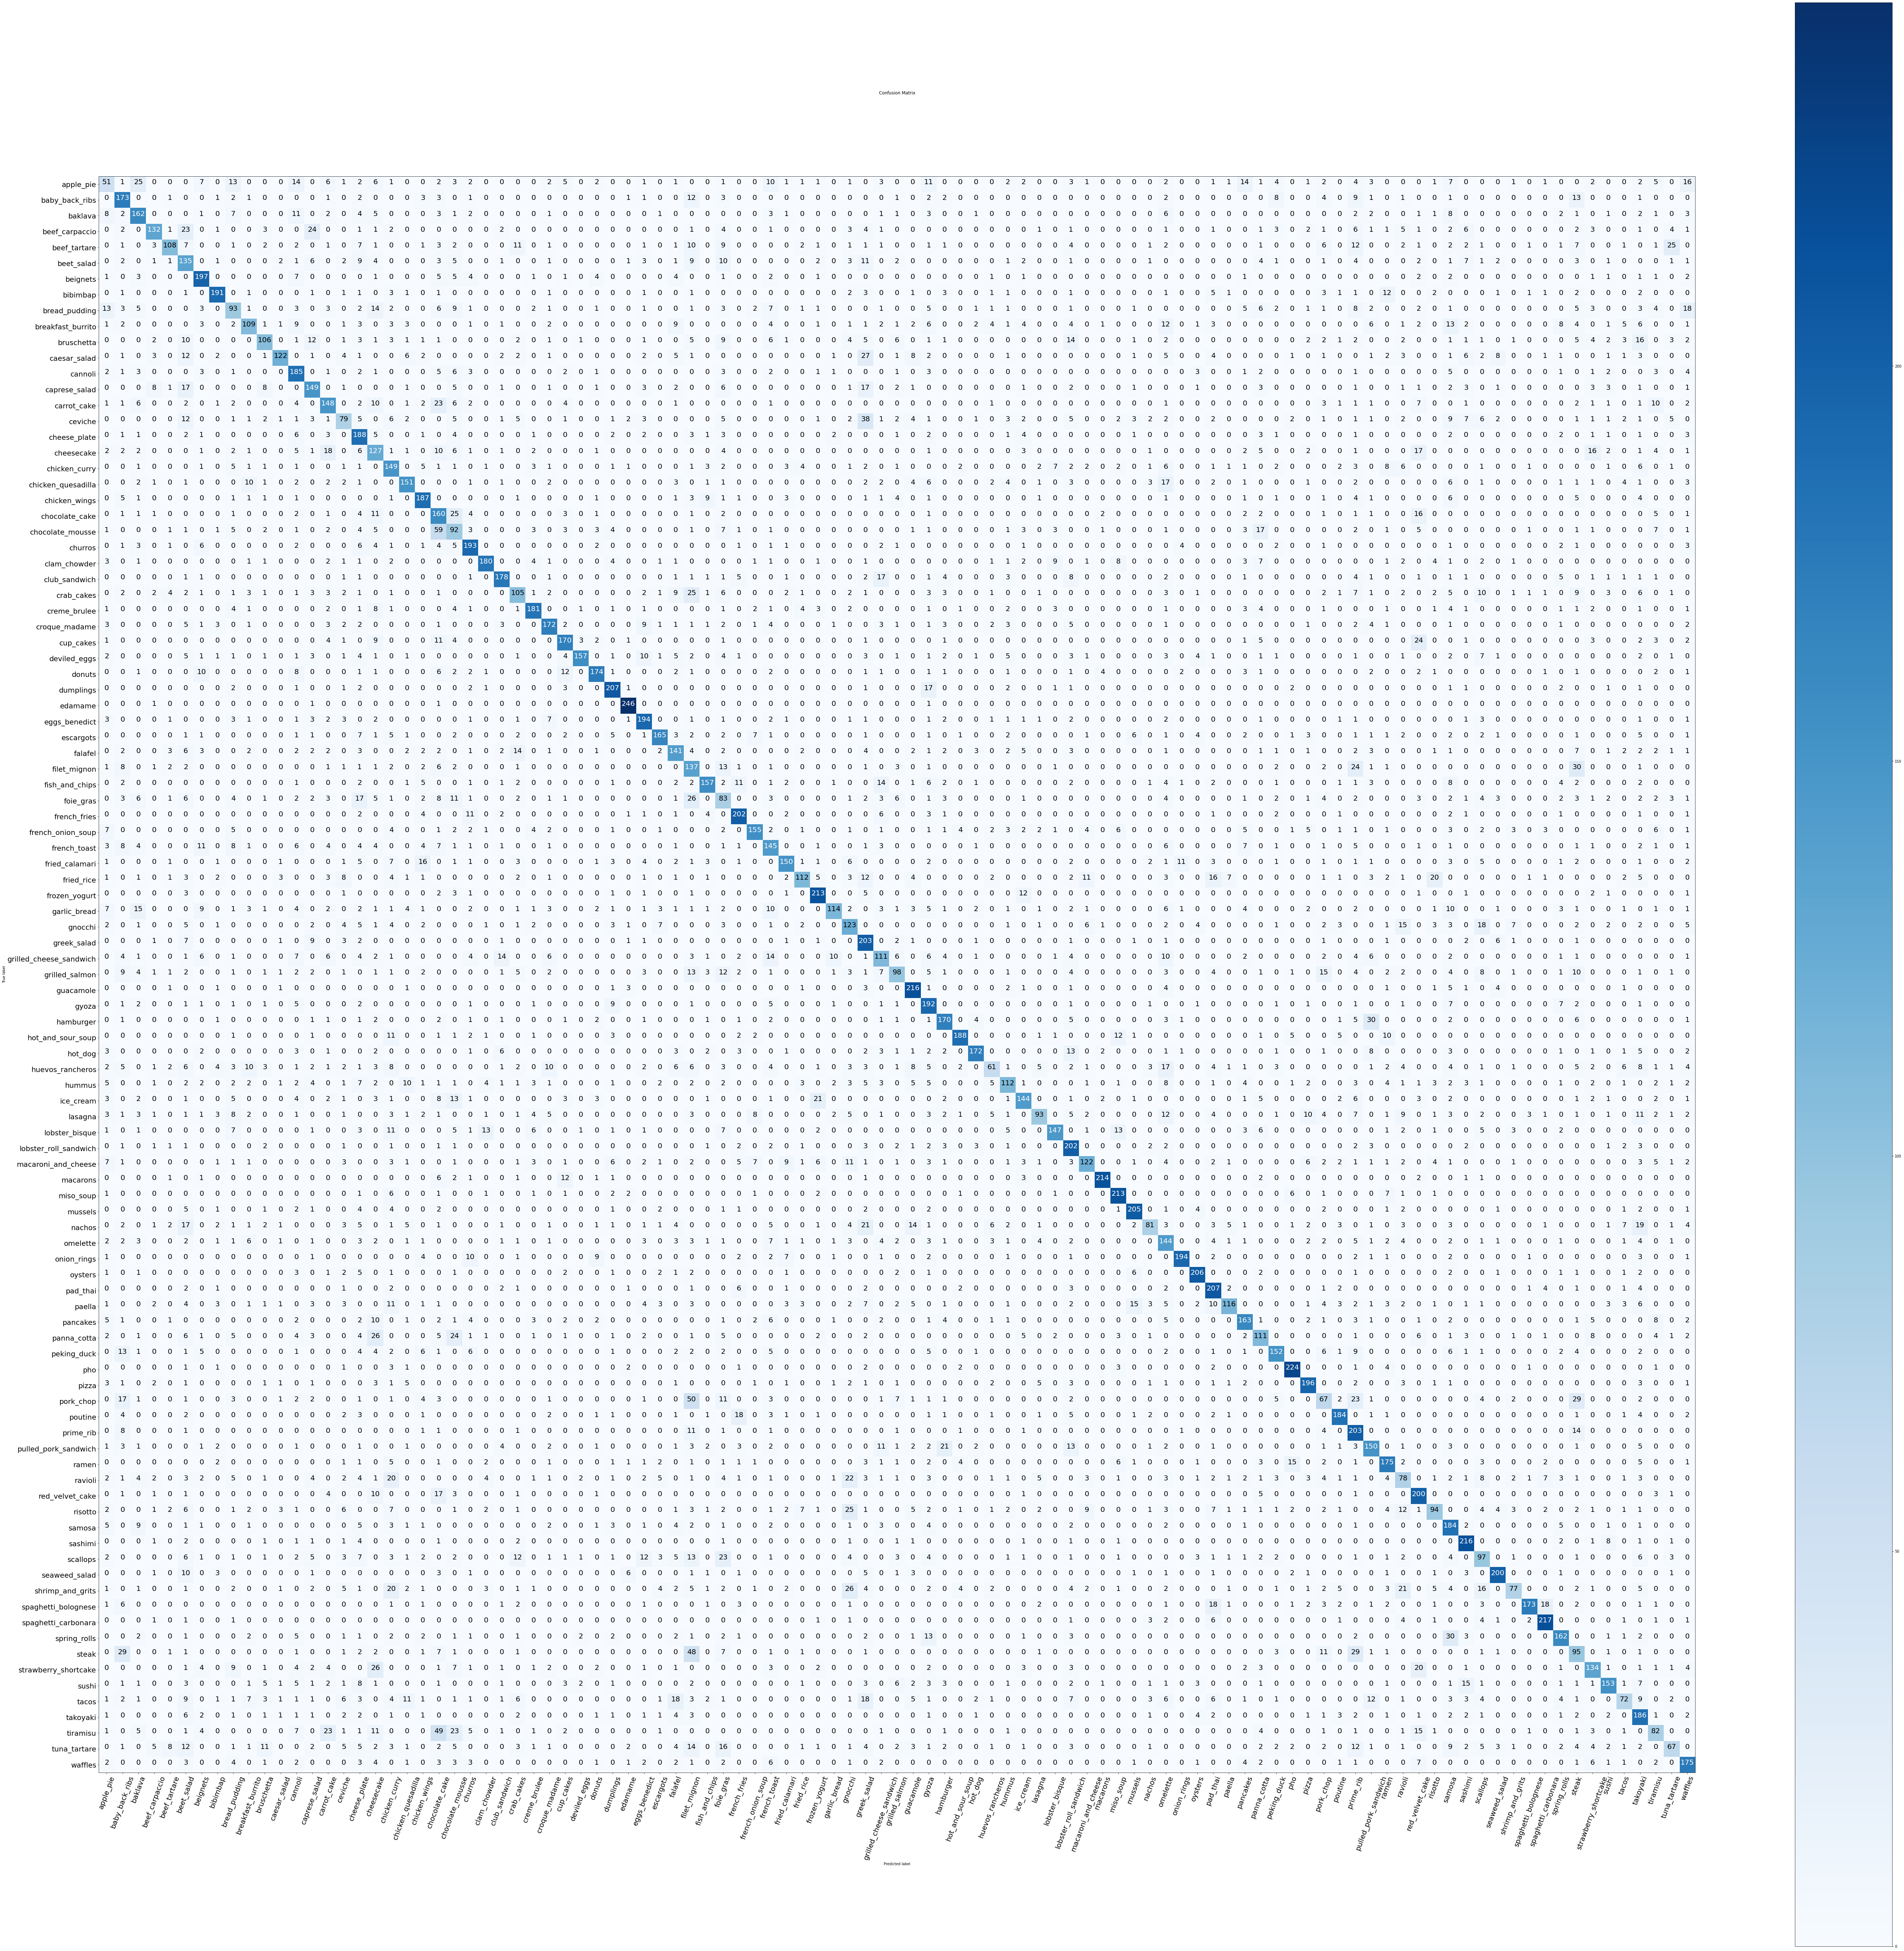

In [ ]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = 20,
                      savefig = True)

Classification- report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

Therefore creating a visualization to get a better understanding.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes,
                                                   output_dict = True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [ ]:
class_names 

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Plot all of the classes F-1 Score

In [ ]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [ ]:
# Create empty dict
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break 
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe.
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)


In [ ]:
len(f1_scores)

101

In [ ]:
f1_scores[90:101]

class_names  f1-score
98          tiramisu  0.385882
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.342857
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566

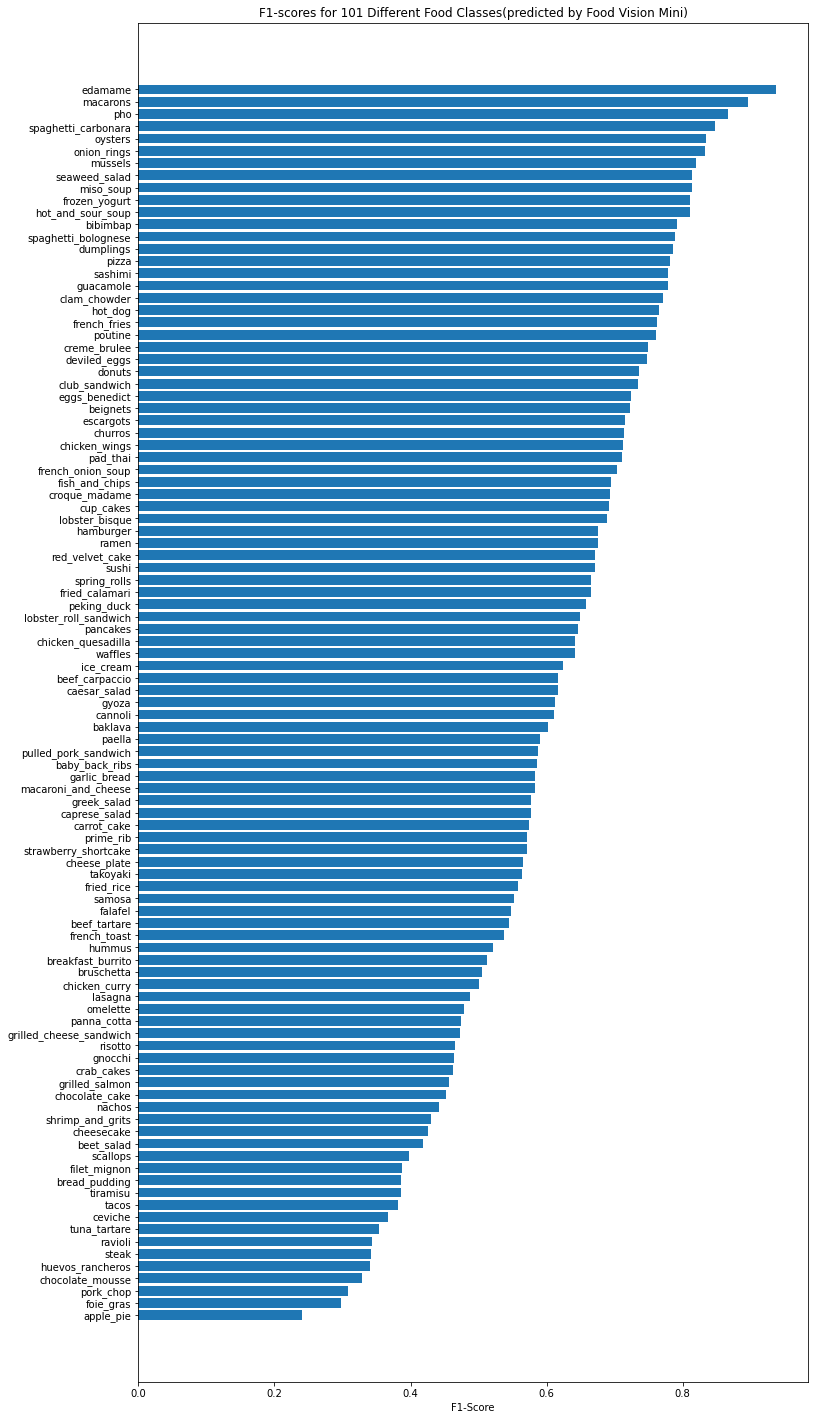

In [ ]:
import matplotlib.pyplot as plt
fig, ax =  plt.subplots(figsize = (12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) #get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-scores for 101 Different Food Classes(predicted by Food Vision Mini)")
ax.invert_yaxis(); # Reverse the order of the plot

## Visualizing predictions on test images.
To visualize our model's predictions on our own images we'll need to load and preprocess images, specifically it will need to:
* Read in a target image file_path using tf.io.read_file
* Turn the image into tensor using tf.io.decode_image()
* Resize the image ytensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values b/w 0 & 1 (if neccessary)

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """"
  Reads in an image from filename turns into a tensor and reshapes into 
  specified shaoe(img_shape, img_shape, color_channels=3)

  Args:
    filenam (str): path to the target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns: 
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? yes/no
  if scale:
    # Rescale the image (get all the values b/w 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale for EfficientNet model in TF.

1. Load a few random images from the dataset
2. Make predictions on the loaded images
3. Plot the orignal image(s) along with the model's predictions, prediction probability and truth label.

In [ ]:
train_data_all_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

1/1 [==============================] - 0s 26ms/step


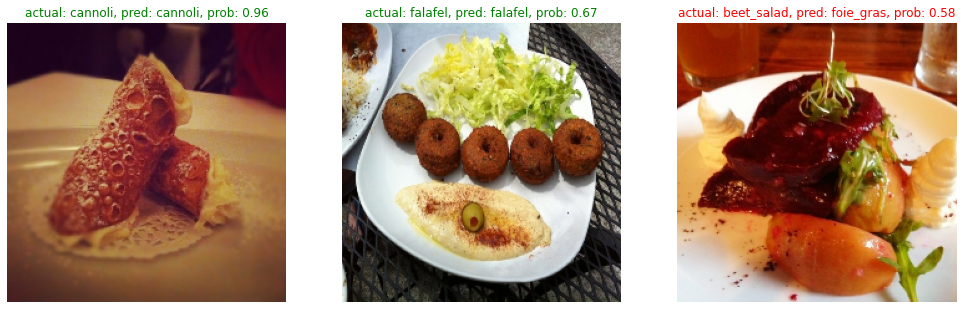

In [ ]:
# Make preds on a series of random images.
import os
import random

plt.figure(figsize = (17, 10))
for i in range(3):
  # Choose a random image from a random class.
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  # Load the image and make predictions

  img = load_and_prep_image(filepath, scale = False)
  
  # print(img.shape)

  img_expanded = tf.expand_dims(img, axis = 0)

  # print(img_expanded.shape)

  pred_prob = model.predict(img_expanded) # get prediction probabilities array.
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
  # print(pred_prob)
  # print(pred_class)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class: # if predicted class matches truth class make text greeen
    title_color = "g"

  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False);

## Finding the most wrong predictions

1. get all of the image filepaths in the test dataset use the list_files() method
2. Create a padndas DataFrame of the image filepaths, ground turth labels, predicted classes from the model, max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the predictions (where the ground truth label does'nt match the prediction).
4. Sort the dataframe based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. get all of the image filepaths in the test data set
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                      shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]



[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the max probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658606        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537900          waffles               waffles  
25248   0.501951          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in the DF which predictions are most wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847419        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658606        apple_pie  pulled_pork_sandwich         False  
4       0.367901        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537900          waffles               waffles          True  
25248   0.501951          waffles  strawberry_shortcake         False  
25249   0.690629          waffles               waffles          True  

[25250 rows x 7 columns]

In [ ]:
# 4. Sort our dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)[:100]
top_100_wrong[:10]

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False

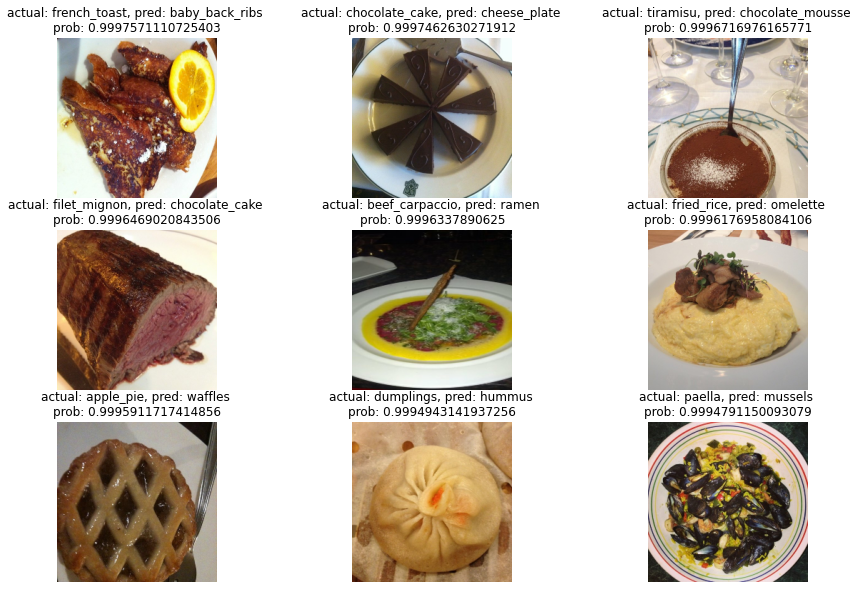

In [ ]:
# 5. Visualize the test_data samples which have the erong prediction
# but highest pred probability

images_to_view = 9
start_index = 20
plt.figure(figsize = (15, 10))
for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale = False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False);

## Test out the big_dog model on our own custom images

In [ ]:
# Get custom images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2023-01-07 07:30:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2023-01-07 07:30:38 (105 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
# get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 24ms/step


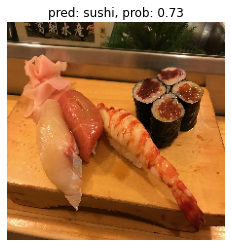

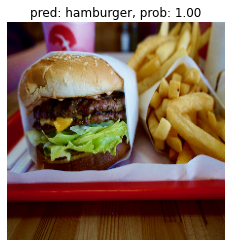

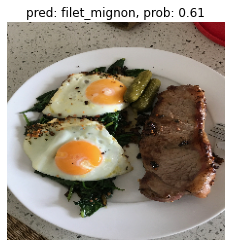

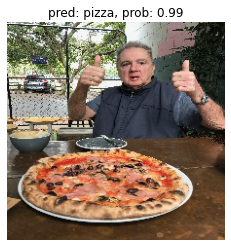

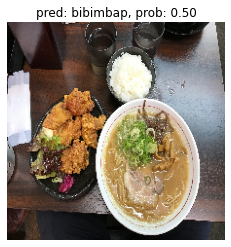

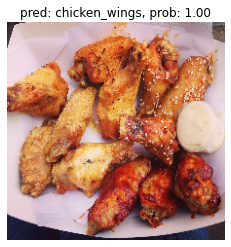

In [ ]:
# Make predictions on and plot the custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0)) #make perdiction on image with shape [1, 224, 224, 3] (same shape it was trained on)
  pred_class = class_names[pred_prob.argmax()] #get the index with highest prediction prob

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);